# TurkishSpamFilterEnhancement-NLP

# Let's Import the libraries

In [1]:
import pandas as pd

In [2]:
#Reading CSV file as pandas Dataframe
df = pd.read_csv("archive/trspam.csv", header=None, encoding="utf-8", on_bad_lines='skip')

In [3]:
df

,0,1,2
0,0.0,0.0,NaN
1,"Sayın Yetkili ,\n Gelişen ve değişen günümüz ...",spam,NaN
2,"Sayın Yetkili,\n \n28 Kasım 2010 tarihli KPSS ...",spam,NaN
3,"Sayın Yetkili ,\n Gelişen ve değişen günümüz ...",spam,NaN
4,T.C.\nURLA KAYMAKAMLIĞI\nURLA HAKAN ÇEKEN ANAD...,spam,NaN
...,...,...,...
698,Ã¶zlem sent you a message.\n\n(no subject)\n\n...,ham,NaN
699,"Sayın Hocalarım, değerli zamanınızı aldığım iç...",ham,NaN
700,PGh0bWw+DQo8aGVhZD4NCjx0aXRsZT5DaGlwJmFtcDtQSU...,ham,NaN
701,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,ham,NaN


# Dataset Cleaning and Reshaping Processes

In [4]:
#Removing na values from dataframe
def dt_na_value_cleaning(data):
    print("\nData Shape : ", data.shape)
    print("\nNull values before removal:: ")
    print(data.isna().sum())
    
    data.dropna(inplace=True)
    data.reset_index(inplace=True,drop=True)
    
    print("\nNull values after removal: ")
    print(data.isna().sum())
    print("\nData Shape after cleaning :" , data.shape)
    
    return data

In [5]:
 # Removing duplicate values
def duplicate_content_removal(dt, col, ini_row):
    dt = dt.iloc[1: , :]
    print("\nNumber of data before removing duplicates: ",ini_row)
    duplicate_count = dt[col].duplicated().sum()
    print("\nNumber of Duplicates: ", duplicate_count)
    
    description_data = dt[col].drop_duplicates()
    cleaned_row = len(description_data)
 
    if (ini_row - cleaned_row) > 0:
        print("\nTotal data reduction : ", (ini_row - cleaned_row))
        print("\nNumber of data after removing duplicates is :", cleaned_row)
    else:
        print("\nNo duplicate data.")
    return list(description_data)             

In [6]:
df=df.rename(columns={0: "E_Mail", 1: "Label", 2:"NaN"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E_Mail  701 non-null    object 
 1   Label   702 non-null    object 
 2   NaN     1 non-null      float64
dtypes: float64(1), object(2)
memory usage: 16.6+ KB


In [7]:
#deleting the unnecessary columns and rows
del df["NaN"]
df = df.iloc[1: , :]
df = df.replace(r'\n',' ', regex=True)
df = dt_na_value_cleaning(df)
E_Mail = duplicate_content_removal(df, 'E_Mail', df.shape[
0])
df.shape
df['Label'].value_counts(normalize=True)# Removing duplicate values


Data Shape :  (702, 2)

Null values before removal:: 
E_Mail    2
Label     1
dtype: int64

Null values after removal: 
E_Mail    0
Label     0
dtype: int64

Data Shape after cleaning : (700, 2)

Number of data before removing duplicates:  700

Number of Duplicates:  66

Total data reduction :  67

Number of data after removing duplicates is : 633


ham     0.594286
spam    0.405714
Name: Label, dtype: float64

# Splitting Dataset into Training and Test Dataset

In [8]:
# Randomize the dataset
data_randomized = df.sample(frac=1, random_state=1)
# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)
# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)
print(training_set.shape)
print(test_set.shape)
training_set['Label'].value_counts(normalize=True)
test_set['Label'].value_counts(normalize=True)

(560, 2)
(140, 2)


ham     0.614286
spam    0.385714
Name: Label, dtype: float64

# Pre-processing

In [9]:
from typing import List
import string
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java, isJVMStarted

In [10]:
#A function for Turkish letters, to fix upper case - lower case issue
def trlower(metin):
    def trlower_(harf):
        if harf=='I': sonuc = 'ı'
        elif harf=='İ': sonuc = 'i'
        else: sonuc = harf.lower()
        return sonuc
    sonuc = ''
    for a in metin:
        sonuc += trlower_(a)
    return sonuc

#Function for removing digits
def sayi(metin): 
    sonuc = ''.join([i for i in metin if not i.isdigit()])
    return sonuc

#Function for removing punctuation
def noktalama(metin):
    sonuc = "".join([i for i in metin if i not in string.punctuation])
    return sonuc

#Function for removing white-spaces
def wspace(metin):
    if metin is None:
        sonuc=''
    sonuc=metin.strip()
    return sonuc

#Function for removing words less than 3 characters
def remove_length(x):
    res = list()
    for word in x:
        if len(word) >= 3:
            res.append(word)
    return " ".join(res)

In [11]:
import os

ZEMBEREK_PATH = 'libs/zemberek-full.jar'

if os.path.isfile(ZEMBEREK_PATH):
    print("File exists")
else:
    print("File does not exist")

File exists


In [12]:
ZEMBEREK_PATH = 'libs/zemberek-full.jar'
import jpype
# Check if JVM is already running
if not jpype.isJVMStarted():
    # Start the JVM
    startJVM(jpype.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % ZEMBEREK_PATH)

In [13]:
def lemmatizer(text):
    TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
    morphology = TurkishMorphology.createWithDefaults()
    analysis: java.util.ArrayList = (morphology.analyzeAndDisambiguate(text).bestAnalysis())
    pos: List[str] = []
    
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}'
        f'\nPrimary POS (Short Form) {i}: {analysis.getPos().shortForm}'
        
        pos.append(f'{str(analysis.getLemmas()[0])}') 
    return " ".join(pos)

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#applying cleaning functions to training data set one at a time to check the results
training_set["E_Mail"] = training_set["E_Mail"].apply(trlower)
training_set["E_Mail"] = training_set["E_Mail"].apply(sayi)
training_set["E_Mail"] = training_set["E_Mail"].apply(noktalama)
training_set["E_Mail"] = training_set["E_Mail"].apply(wspace)

#Removing Turkish stopwords with NLTK library
training_set['E_Mail'] = training_set['E_Mail'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

training_set['E_Mail'] = training_set['E_Mail'].str.split().apply(remove_length)

training_set["E_Mail"] = training_set["E_Mail"].apply(lemmatizer)
#since ZEMBEREK lemmatizer gives UNK as output 
# if a word cannot be processed, replacing it with ‘’

training_set["E_Mail"] = training_set["E_Mail"].str.replace("UNK", '')
training_set.head()

,E_Mail,Label
0,hafta genel haziran sayı küçük işle siber s...,ham
1,html head meta meta head body table ...,ham
2,hoca ben matematik ortalama bütünle gir ol gen...,ham
3,merhaba veri site tekrar durum ilgi ...,ham
4,from başbakan mar from muhteşem...,ham


In [11]:
#applying cleaning functions to training data set one at a time to check the results
df["E_Mail"] = df["E_Mail"].apply(trlower)
df["E_Mail"] = df["E_Mail"].apply(sayi)
df["E_Mail"] = df["E_Mail"].apply(noktalama)
df["E_Mail"] = df["E_Mail"].apply(wspace)

#Removing Turkish stopwords with NLTK library
df['E_Mail'] = df['E_Mail'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df['E_Mail'] = df['E_Mail'].str.split().apply(remove_length)


df["E_Mail"] = df["E_Mail"].str.replace("UNK", '')
df.head()

NameError: name 'stop_words' is not defined

In [ ]:
#applying cleaning functions to training data set one at a time to check the results
test_set["E_Mail"] = test_set["E_Mail"].apply(trlower)
test_set["E_Mail"] = test_set["E_Mail"].apply(sayi)
test_set["E_Mail"] = test_set["E_Mail"].apply(noktalama)
test_set["E_Mail"] = test_set["E_Mail"].apply(wspace)

#Removing Turkish stopwords with NLTK library
test_set['E_Mail'] = test_set['E_Mail'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

test_set['E_Mail'] = test_set['E_Mail'].str.split().apply(remove_length)

test_set["E_Mail"] = test_set["E_Mail"].apply(lemmatizer)
#since ZEMBEREK lemmatizer gives UNK as output 
# if a word cannot be processed, replacing it with ‘’

test_set["E_Mail"] = test_set["E_Mail"].str.replace("UNK", '')
test_set.head()

In [ ]:
training_set.to_csv('train_p.csv',sep=',',index=False);
test_set.to_csv('test_p.csv',sep=',',index=False);

# EDA

## 1. Data Overview: 

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E_Mail  700 non-null    object
 1   Label   700 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB
None


## 2. Label Distribution:

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


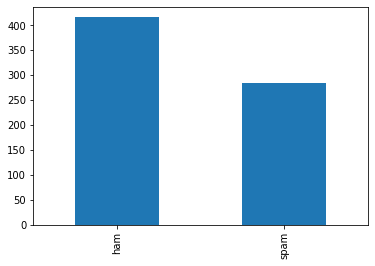

In [18]:
import matplotlib.pyplot as plt
df['Label'].value_counts().plot(kind='bar')
plt.show()

## 3. Text Length Analysis:

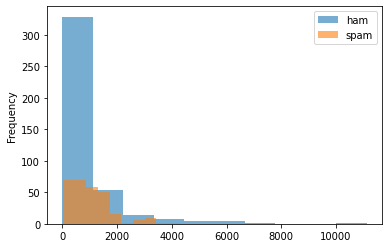

In [19]:
df['text_length'] = df['E_Mail'].apply(len)
df.groupby('Label')['text_length'].plot(kind='hist', alpha=0.6)
plt.legend()
plt.show()

## 4. Word Frequency Analysis

[('ol', 2262), ('bir', 2230), ('et', 1017), ('the', 785), ('yap', 758), ('al', 688), ('bilgi', 648), ('ver', 635), ('mezun', 573), ('de', 465), ('adres', 462), ('ben', 460), ('and', 458), ('kurum', 454), ('muhasebe', 443), ('konu', 401), ('siz', 384), ('windows', 368), ('personel', 365), ('yer', 364)]


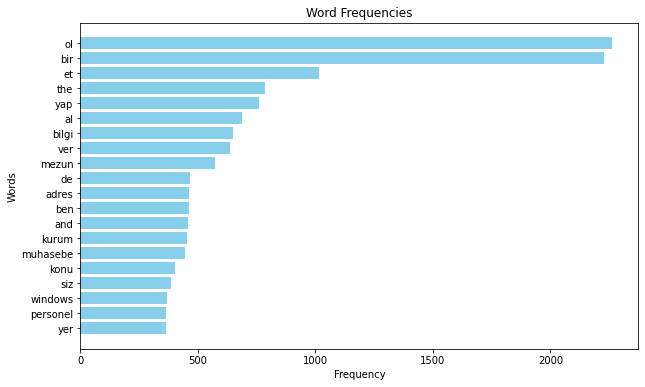

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=20)
word_count = cv.fit_transform(df['E_Mail'])
sum_words = word_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq)
# Convert list of tuples into a DataFrame
df2 = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10,6))
plt.barh(df2['Word'], df2['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Word Frequencies')
plt.gca().invert_yaxis()  # Reverse the order of words
plt.show()

## 5. Word Cloud:

In [21]:
import matplotlib.font_manager
font_path = matplotlib.font_manager.findfont('Arial')
print(font_path)


C:\Windows\Fonts\arial.ttf


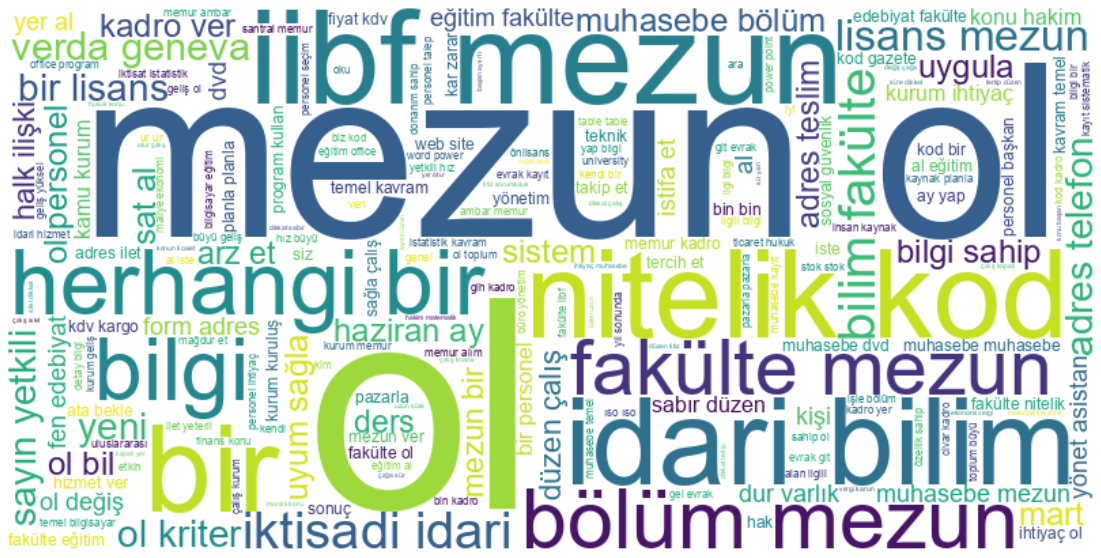

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = ' '.join(list(df[df['Label']=='spam']['E_Mail']))
spam_wc = WordCloud(background_color="white", width=800, height=400, font_path='C:\\Windows\\Fonts\\arial.ttf').generate(spam_words)

plt.figure(figsize=(30, 10))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()


# Classification (First Approach)

In [23]:
#creating the vocabulary
training_set['E_Mail'] = training_set['E_Mail'].str.split()
vocabulary = []
for email in training_set['E_Mail']:
    for word in email:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))
len(vocabulary)

6773

In [24]:
# Creating the dataframe to calculate probabilities on
word_counts_per_email = {unique_word: [0] * len(training_set['E_Mail']) for unique_word in vocabulary}
for index, email in enumerate(training_set['E_Mail']):
    for word in email:
        word_counts_per_email[word][index] += 1
word_counts = pd.DataFrame(word_counts_per_email)
word_counts.head()
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,E_Mail,Label,redmond,denizli,muallim,çekik,mesih,görev,imza,zam,...,kazan,sein,irade,bayramoğlu,saldırgan,cümleten,bina,kiremit,sözkonusu,yanaz
0,"[hafta, genel, haziran, sayı, küçük, işle, sib...",ham,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[html, head, meta, meta, head, body, table, ta...",ham,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[hoca, ben, matematik, ortalama, bütünle, gir,...",ham,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[merhaba, veri, site, tekrar, durum, ilgi, aya...",ham,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[from, başbakan, mar, from, muhteşem, bir, mek...",ham,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
#Isolating spam and ham messages first
spam_emails = training_set_clean[training_set_clean['Label'] == 'spam']
ham_emails = training_set_clean[training_set_clean['Label'] == 'ham']
# P(Spam) and P(Ham)
p_spam = len(spam_emails) / len(training_set_clean)
p_ham = len(ham_emails) / len(training_set_clean)
# N_Spam
n_words_per_spam_emails = spam_emails['E_Mail'].apply(len)
n_spam = n_words_per_spam_emails.sum()
# N_Ham
n_words_per_ham_emails = ham_emails['E_Mail'].apply(len)
n_ham = n_words_per_ham_emails.sum()
# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}
# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_emails[word].sum() # spam_messages already defined
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    n_word_given_ham = ham_emails[word].sum() # ham_messages already defined
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham+ alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

### Applying bayes theorem

In [26]:
import re

In [27]:
def classify(email):
    email = re.sub('\W', ' ', email )
    email = email.lower().split()
    
    p_spam_given_email = p_spam
    p_ham_given_email = p_ham
    
    for word in email:
        if word in parameters_spam:
            p_spam_given_email *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_email *= parameters_ham[word]
        print('P(Spam|email):', p_spam_given_email)
        print('P(Ham|email):', p_ham_given_email)
    if p_ham_given_email > p_spam_given_email:
        print('Label: Ham')
    elif p_ham_given_email < p_spam_given_email:
        print('Label: Spam')
    else:
        print('Label: Ham')

In [28]:
def classify_test_set(email):
    email = re.sub('\W', ' ', email )
    email = email.lower().split()
    
    p_spam_given_email = p_spam
    p_ham_given_email = p_ham
    
    for word in email:
        if word in parameters_spam:
            p_spam_given_email*= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_email *= parameters_ham[word]
        
    if p_ham_given_email > p_spam_given_email:
        return 'ham'
    elif p_spam_given_email > p_ham_given_email:
        return 'spam'
    else:
        return 'ham'

In [29]:
test_set['predicted'] = test_set['E_Mail'].apply(classify_test_set)

### Accuracy Metrics

In [30]:
#Accuracy Metrics
correct = 0
total = test_set.shape[0]
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

#False Positive and False Negative Metrics
fp=0
fn=0
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == 'spam':
        if row['predicted']=='ham':
            fn+=1
    if row['Label'] == 'ham':
        if row['predicted']=='spam':
            fp+=1
print('False Negative Ratio:', fn/total*100)
print('False Positive Ratio:', fp/total*100)

Correct: 104
Incorrect: 36
Accuracy: 0.7428571428571429
False Negative Ratio: 22.857142857142858
False Positive Ratio: 2.857142857142857


## Classification (Second Approach)

In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('turkish'))
82
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import string
from typing import List
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
text = pd.DataFrame(df['E_Mail'])
label = pd.DataFrame(df['Label'])

In [33]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['E_Mail'])
vectors.shape
#features = word_vectors
features = vectors

In [34]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, df['Label'], test_size=0.15, random_state=111)

In [35]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [36]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}
clfs

{'SVC': SVC(gamma=1.0, kernel='sigmoid'),
 'KN': KNeighborsClassifier(n_neighbors=49),
 'NB': MultinomialNB(alpha=0.2),
 'DT': DecisionTreeClassifier(min_samples_split=7, random_state=111),
 'LR': LogisticRegression(penalty='l1', solver='liblinear'),
 'RF': RandomForestClassifier(n_estimators=31, random_state=111)}

In [37]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

#getting the accuracy scores of the classifiers using tfidf vectorizing
pred_scores_word_vectors

AttributeError: 'NoneType' object has no attribute 'split'